# Computer Vision - Intrusion Detection Project
Burroni Luca - 0001003892

In [1]:
# Python 3.12.0
# opencv-python 4.8.1.78
# matplotlib 3.8.0

In [2]:
# import libraries
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

# input
video_path = 'C:\\Users\\lucab\\Desktop\\UniBo\\Computer Vision\\Progetto\\video\\rilevamento-intrusioni-video.avi'

# output
txt_path = 'C:\\Users\\lucab\\Desktop\\UniBo\\Computer Vision\\Progetto\\output\\output.txt'
output_video_path = 'C:\\Users\\lucab\\Desktop\\UniBo\\Computer Vision\\Progetto\\output\\output.avi'

# parameters
w = 320
h = 240
fps = 12
threshold = 10  # mask threshold

## Utility Functions

In [3]:
def print_image(image):
    # print gray-scale image
    plt.axis('off')
    plt.imshow(image.astype(np.uint8), cmap='gray', vmin=0, vmax=255)
    plt.show()

In [4]:
def plot_images(img_1, img_2):
    # plot two gray-scale images, used for a frame and the relative mask
    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.imshow(img_1.astype(np.uint8),cmap='gray',vmin=0,vmax=255)
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.imshow(img_2.astype(np.uint8), cmap='gray', vmin=0, vmax=255)
    plt.show()

## Background initialization
The chosen solution involves the use of <b>selective background initialization instead of blind</b>.<br>
In fact, as indicated in the "Change Detection" lecture, only the values corresponding to frames in which the pixel has been voted as belonging to the background (<b>through temporal two-frame difference + morphological operations</b>) are 'selectively' considered for each pixel.<br>
This way, by using as few initial frames as possible (as required by the command), a good background is still obtained.<br>
The <b>median</b> is used as central tendency measure.<br> 
The number of initial frames used is that for which we have at least <i>median_values_threshold</i> (default 5) not nan (selected) values per pixel. <br>
That number is then returned as a parameter by the <i>selective_background_initialization</i> method and used in <i>blind_background_initialization</i> to compare the background obtained with a blind median of the same number of initial frames.

In [5]:
# blind Background Initialization method
def blind_background_initialization(frames, n_frames):
    # initialize background using median of pixel values in first n frames
    background = np.median(frames[:n_frames], axis=0).astype(np.uint8)
    return background

In [6]:
# selective Background Initialization method
def selective_background_initialization(frames, median_values_threshold = 5):
    # perform selective background update using temporal two-frame difference and morphological operations
    
    _, height, width = frames.shape
    prev = frames[0]
    n_frames = 1 # used frames count. Start from one because the first is used as initial previous frame and "skipped"
    background_pixels = []
    
    while(True):
        #check to have at least median_values_threshold not nan values for each pixel
        if not np.all(np.sum(~np.isnan(background_pixels), axis=0) >= median_values_threshold):
        
            # compute temporal difference between current frame and previous one
            diff_frame = cv2.absdiff(frames[n_frames], prev)

            # threshold the difference frame to get binary foreground mask
            _, fg_mask = cv2.threshold(diff_frame, threshold, 255, cv2.THRESH_BINARY)

            # perform morphological operations
            # opening (remove small size blobs)
            kernel = np.ones((3, 3), np.uint8)
            fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, kernel)

            # iterated closing (fill holes in person figure)
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
            fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_CLOSE, kernel, iterations = 12)

            # opening (remove other blobs)
            kernel = np.ones((9, 9), np.uint8)
            fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, kernel)

            # update background pixels with corresponding frame pixels if they are part of the background
            background_frame = np.full((height, width), np.nan) # tmp structure
            background_frame[fg_mask == 0] = frames[n_frames, fg_mask == 0]
            background_pixels.append(background_frame)

            # update previous frame
            prev = frames[n_frames]
            
            # add one to number of used frames
            n_frames += 1
        else:
            break
    
    background = np.nanmedian(background_pixels, axis=0).astype(np.uint8)
    
    return background, background_pixels, n_frames

## Background updating
For background updating <b>selective alpha-blending</b> procedure is used. <br>
<i>c</i> is the alpha adaptation rate (default 0.4)

In [7]:
def selective_background_updating(fg_mask, gray_frame, background, c=0.4):
    # selective background updating
    change_indexes = fg_mask == 0
    if np.sum(change_indexes) > 0:
        background_updated[change_indexes] = (c * gray_frame[change_indexes]) + (1 - c) * background[change_indexes]
    return background_updated
    

# Canny's edges detector
Automatic detection of thresholds. Gaussian Blurring (kernel 5x5) applied.

In [8]:
def canny_edge_detection(gray_frame, sigma=0.33, kernel = (5, 5)):
    # blur image
    blurred = cv2.GaussianBlur(gray_frame, kernel, 0)
    # get thresholds
    md = np.median(blurred)
    lower_value = int(max(0, (1.0-sigma) * md))
    upper_value = int(min(255, (1.0+sigma) * md))
    # apply canny's edge detector
    frame_edges = cv2.Canny(blurred, lower_value, upper_value)
    return frame_edges

## Connected components labeling
Also blob features extraction and classification

In [9]:
def connected_components_labeling(mask, frame_edges, connectivity = 8, area_threshold = 5000, edge_treshold = 50):
    
    # apply the component analysis function
    labels, labeled_image, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity, cv2.CV_32S)

    components = []
    presence = '-'

    output = np.zeros(mask.shape, dtype="uint8")

    # loop through each component 
    for label_id in range(labels): 
        
        if label_id == 0:
            # background
            continue
            
        # isolate object mask
        object_mask = (labeled_image == label_id).astype("uint8")
            
        # get area, perimeter and baricentre
        area = stats[label_id, cv2.CC_STAT_AREA]
        barycentre = [round(centroids[label_id, 0], 2), round(centroids[label_id, 1], 2)]
        contours, _ = cv2.findContours(object_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        cnt = contours[0]
        perimeter = cv2.arcLength(cnt, True)
        
        # classify 'person' or 'other' based on area
        classification = 'person' if area >= area_threshold else 'other'
        # if 'other' classify as 'true' or 'false'
        if classification == 'other':
            # get blob contours
            component_edges = np.zeros(mask.shape, dtype=np.uint8)
            cv2.drawContours(component_edges, contours, -1, (255), thickness=2) # thickness as an error margin
            # compare blob contours with frame edges to decide if an object is true (still present on the scene)
            overlap_pixels = np.sum(np.logical_and(frame_edges, component_edges))
            presence = 'true' if overlap_pixels >= edge_treshold else 'false'
        
        # give a different color to the object mask
        color = np.uint8(179 * (label_id)/labels - 1)
        object_mask_colored = object_mask * color

        # apply the mask using the bitwise operator 
        output = cv2.bitwise_or(output, object_mask_colored)
        
        # append component with all the relative parameters to output structure
        components.append({
            'id': label_id,
            'area': round(area,2),
            'perimeter': round(perimeter, 2),
            'barycentre': barycentre,
            'classification': classification,
            'presence': presence
        })

    # converting HSV to RGB
    white_channel = 255*np.ones_like(output, dtype=np.uint8)
    output = cv2.merge([output, white_channel, white_channel])
    output = cv2.cvtColor(output, cv2.COLOR_HSV2RGB)
    output[labeled_image==0] = 0
    
        
    return output, components, labels

## Generate background

Initial frames used: 20


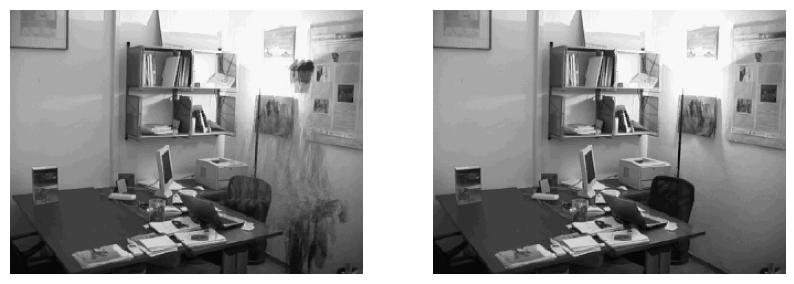

In [10]:
# read video frames
cap = cv2.VideoCapture(video_path)

frames = []
while(True):
    ret, frame = cap.read()
    if not ret or frame is None:
        cap.release()
        break
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # convert
    frames.append(gray_frame)
frames = np.array(frames)

# compute background using selective approach
background_selective, background_selective_pixels, n_frames = selective_background_initialization(frames)

# compute background using blind approach
background_blind = blind_background_initialization(frames, n_frames)

# display the results
print("Initial frames used: " + str(n_frames))
plot_images(background_blind, background_selective)

## Process video and get outputs

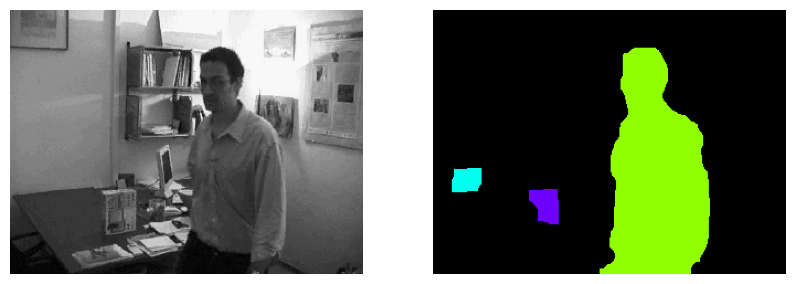

In [11]:
cap = cv2.VideoCapture(video_path)
output_video = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc('M','J','P','G'), fps, (w,h))
fp = open(txt_path,'w')

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
background_updated = background_selective.copy()

i = 0

# iterate
while(True):
    ret, frame = cap.read()
    
    if not ret or frame is None:
        cap.release()
        output_video.release()
        fp.close()
        break
        
    if i > (n_frames-1):
        
        # convert
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # subtract background
        diff_frame = cv2.absdiff(gray_frame, background_updated)

        # threshold the difference frame to get binary foreground mask
        _, fg_mask = cv2.threshold(diff_frame, threshold, 255, cv2.THRESH_BINARY)
        
        # perform morphological operations
        # opening (remove small size blobs)
        kernel = np.ones((3, 3), np.uint8)
        fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, kernel)
        
        # closing (fill holes)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (17,17))
        fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_CLOSE, kernel)
        
        # opening (remove other blobs)
        kernel = np.ones((9, 9), np.uint8)
        fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, kernel)
        
        # get frame edges using Canny
        frame_edges = canny_edge_detection(gray_frame)

        # call function to get results
        labeled_mask, components, labels = connected_components_labeling(fg_mask, frame_edges)

        # write results in both txt file and output video
        output_video.write(labeled_mask)
        fp.write(str(i) + '\t' + str(labels - 1) + '\n')
        for component in components:
            fp.write('{0}\t{1}\t{2}\t{3}{4}\t{5}\t{6}\n'.format(
                component['id'],
                component['perimeter'],
                component['area'],
                component['barycentre'],
                '\t' if len(str(component['barycentre'])) <= 15 else '',
                component['classification'],
                component['presence']))
        fp.write('\n')

        # plot current frame with relative labeled mask 
        if i == (total_frames-1):
            plot_images(frame, labeled_mask)

        # Background updating
        background_updated = selective_background_updating(fg_mask, gray_frame, background_updated)

    i += 1
    
    